# Imports

In [2]:
mount_dir = '/content/drive'

from google.colab import drive
drive.mount(mount_dir)

# install the package
# %pip install -q sign-language-translator
# %pip install -e "/content/drive/Othercomputers/mac19/personal_repos/slt/sign-language-translator"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import os
import re
from collections import Counter, OrderedDict
from copy import deepcopy
from importlib import reload

from IPython.display import clear_output
from tqdm.auto import tqdm

from time import time
from typing import Dict, List

from numpy.random import shuffle

# local
SLD = "/Users/mudassar.iqbal/Library/CloudStorage/GoogleDrive-mdsriqb@gmail.com/My Drive/sign-language-translator/sign-language-datasets"
# google colab
# SLD = os.path.abspath(os.path.join(mount_dir, 'MyDrive', 'sign-language-translator', "sign-language-datasets"))

import sign_language_translator as slt
reload(slt)
# slt.set_resources_dir(SLD)

from sign_language_translator.languages.text import urdu
reload(urdu)

nlp = urdu.Urdu()

from sign_language_translator.text.utils import extract_supported_subsequences, concatenate_sentence_terminals

clear_output()

## Load Data

In [2]:
def dataset_lines():
    with open(f'{SLD}/text_corpora/raw_corpora/glosbe.json', 'r') as f:
        for line in tqdm(json.load(f), desc="glosbe"):
            yield nlp.preprocess(line)

    with open(f'{SLD}/text_corpora/raw_corpora/rekhta_categories.json', 'r') as f:
        rekhta_categories: Dict[str, List[str]] = json.load(f)
    with open(f'{SLD}/text_corpora/raw_corpora/rekhta.json', 'r') as f:
        rekhta = json.load(f)
        rekhta_preprocessor = {
            "poetry": nlp.poetry_preprocessor,
            "passage": nlp.passage_preprocessor,
        }
        for group, keys in rekhta_categories.items():
            for key in tqdm(keys, desc=f"{group}"):
                for text in rekhta[key]:
                    yield rekhta_preprocessor[group](
                        nlp.preprocess(text)
                    )
    with open(f'{SLD}/text_corpora/raw_corpora/wikipedia.txt', 'r') as f:
        for line in tqdm(f, desc="wikipedia", total=2637230):
            yield nlp.preprocess(
                nlp.wikipedia_preprocessor(line)
            )
    with open('/Users/mudassar.iqbal/Desktop/datasets/news.txt', 'r') as f:
        for line in tqdm(f, desc="news", total=2_956_733):
            yield nlp.preprocess(line)

## Extract supported substrings

In [2]:
extracts = {}

allowed_tags = {
    urdu.Tags.SPACE, urdu.Tags.PUNCTUATION,
    urdu.Tags.NAME,
    urdu.Tags.SUPPORTED_WORD,
    urdu.Tags.ACRONYM, urdu.Tags.NUMBER,
    urdu.Tags.AMBIGUOUS,
}
skipped_items = {"0", "۰"} | set("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

def all_numbers(tokens:List[str], tags:List):
    return all(tag in {urdu.Tags.NUMBER, urdu.Tags.PUNCTUATION} for tag in tags)

def all_characters(tokens:List[str], tags:List):
    return all(len(t)==1 for t in tokens)

def bad_length(tokens:List[str], tags:List):
    return len([t for t in tokens if t !=" "])<=1

line_filters = [
    # all_numbers,
    bad_length
]

In [4]:
dataset_gen = dataset_lines()
counts = {}
for line in dataset_gen:
    tokens = nlp.tokenize(line)
    tags = nlp.get_tags(tokens)
    subs = extract_supported_subsequences(tokens, tags, allowed_tags, skipped_items)
    subs = [sub for sub in subs if not any(func(sub, []) for func in line_filters)]
    for sentence in [nlp.detokenize(sub) for sub in subs]:
        if sentence not in counts:
            counts[sentence] = 0
        counts[sentence] += 1

sorted_counts = sorted(counts.items(), key=lambda item: (item[0].count(" "), item[1], item[0]), reverse=True)

clear_output()
print("frequency sum", sum(counts.values()))
print("unique lines ", len(counts))
print("\n".join(map(str,sorted_counts[:10])))
print("\n\n")

frequency sum 111354033
unique lines 15445944
(' ہیں 000885 024894 045798 067101 092067 110967 130617 152388 175205 194925 213571 001489 025380 045885 068801 092443 111134 130782 152944 175309 194989 213886 001934 025873 046343 069239 092953 111436 130811 153525 176046 195140 213987 001982 026140 046788 069335 093231 111880 131057 154578 176375 195205 214654 002329 026181 047157 069762 093760 112016 131656 154773 176711 195325 214795 004358 026416 047346 069887 093824 112118 132051 155398 177151 195790 215484 005124 026573 047932 070231 094786 112947 132330 155506 177457 196415 216789 005728 026868 047945 071386 095040 113319 133017 155865 177845 196605 217148 005924 027133 048081 071609 095789 114503 133086 156158 178168 196830 217591 006331 027152 048383 072284 096503 115024 133303 156434 178356 197208 217600 006463 027265 048685 072350 097071 115033 133358 157040 178823 197345 218183 008592 027711 049231 072647 097468 115442 133418 157175 178845 197875 218649 008732 027974 049840 07

In [ ]:
sentence_lengths = Counter([sent.count(' ') for sent in counts.keys()])
sorted(sentence_lengths.most_common())

In [10]:
with open(f'{SLD}/text_corpora/supported_substrings_frequency.json', "w") as f:
    json.dump(OrderedDict(sorted_counts), f, indent=2, ensure_ascii=False)

In [ ]:
del extracts

## make LM training dataset
- sentence tokenize
- add start, end tokens
- make 1 sentence per line file

In [2]:
# final_data
with open(SLD+'/text_corpora/supported_substrings_frequency.json', 'r') as f:
    raw_data = json.load(f)
len(raw_data)

15095265

In [3]:
sos, eos = "<", ">"

In [20]:
# joint_data = {}
# for category in ['poetry', 'passage', 'glosbe', "news"]#, 'wikipedia']:
#     for substring, freq in tqdm(list(raw_data[category].items())[:], desc=category):
#         if substring not in joint_data:
#             joint_data[substring] = 0
#         joint_data[substring] += freq
# del raw_data

processed_data = []
# for substring, freq in tqdm(joint_data.items()):
for substring, freq in tqdm(list(raw_data.items())[:]):
    sentences = nlp.sentence_tokenize(substring)
    sentences = concatenate_sentence_terminals(sentences, sos, eos)
    sentences = [sen for sen in sentences if sen not in {sos, eos}]
    sentences = sentences * max(1, round(freq ** 0.3)) # lets accept a little bit of repetition

    processed_data.extend(sentences)

# del joint_data
shuffle(processed_data)

print(len(processed_data))
print(processed_data[90:100])

  0%|          | 0/15095265 [00:00<?, ?it/s]

In [29]:
# with open(SLD+'/text_corpora/ur-lm-data.txt', 'w') as f:
with open('../model_training/data/ur-lm-dataset.txt', 'w') as f:
    f.write("\n".join(processed_data))

# frequency analysis

In [9]:
# count
# with open(f'../model_training/data/ur-lm-dataset.txt', 'r') as f:
#     counts = Counter(tok for line in tqdm(f, total=20_574_921) for tok in nlp.tokenize(line))

# break acronyms and numbers into characters
counts_2 = {}
for word,count in counts.items():
    for tok in (
        list(word)
        if nlp.get_tags(word)==[slt.text.Tags.ACRONYM]
        else re.findall(
            r"("
            + r"|".join(sorted(nlp.vocab.numeric_keys, key=len, reverse=True))
            + r"|[^\D0۰]|\.|[^0۰])",
            word,
        ) if word.replace(".", "").isnumeric()
        else [word]
    ):
        if tok not in counts_2:
            counts_2[tok] = 0
        counts_2[tok] += count

# save
with open(f'../model_training/data/ur-lm-dataset-token-counts.json', 'w') as f:
    json.dump(
        OrderedDict(sorted(counts_2.items(), key=lambda item: (item[1],item[0]), reverse=True)),
        f, indent=4, ensure_ascii=False
    )
len(counts), len(counts_2)

(120137, 2444)

In [ ]:
with open('acronyms.txt', 'w') as f:
    f.write("\n".join(sorted([k for k in counts if k.isupper()])))


class weights

In [2]:
import json
with open(f'../model_training/data/ur-lm-dataset-token-counts.json') as f:
    counts = json.load(f)

In [ ]:
from collections import Counter
from tqdm.auto import tqdm
ccounts = Counter("".join("".join([w]*c) for w,c in counts.items()))
ccounts.most_common()

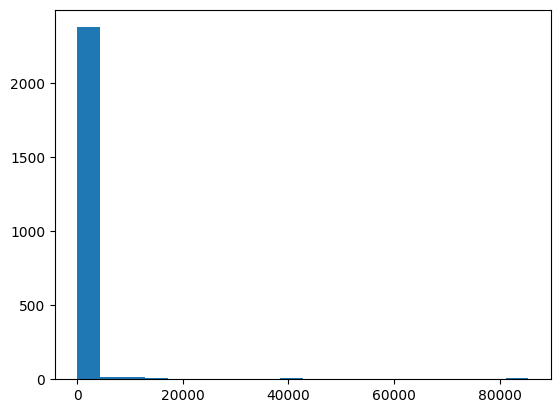

In [103]:
import numpy as np
import matplotlib.pyplot as plt
total = sum(counts.values())
# class_weights = {w:np.log(1/c) for w,c in counts.items()}
class_weights = {w:(1/c) * total/len(counts) for w,c in counts.items()}
# class_weights = {w:np.log(c) for w,c in counts.items()}
# class_weights = {c:w-np.mean(list(class_weights.values())) for c,w in class_weights.items()}
# class_weights = {c:w/np.std(list(class_weights.values())) for c,w in class_weights.items()}
class_weights = {c:w-min(class_weights.values()) for c,w in class_weights.items()}
# class_weights = {w:np.e ** c for w,c in counts.items()}
# class_weights = {c:max(float("-inf"),w-min(class_weights.values())) for c,w in class_weights.items()}
# class_weights = {c:w**(1/np.e) for c,w in class_weights.items()}
# class_weights = {c:w for c,w in class_weights.items()}

_ =plt.hist(class_weights.values(), bins=20)

In [107]:
sum(counts.values())

208826619

In [106]:
sum(class_weights.values())

2283728.13512792

In [ ]:
sorted(class_weights.items(), key=lambda item: item[1], reverse=True)

In [53]:
with open("../model_training/models/token_to_id.json", 'r') as f:
    token_to_id = json.load(f)
id_to_token = {v:k for k,v in token_to_id.items()}
vocab_size = 2560

In [55]:
import torch
torch.save(
    torch.Tensor([class_weights.get(id_to_token.get(i, -1), 1) for i in range(vocab_size)]),
    "../model_training/models/ur-lm-class-weights.pt"
)

In [ ]:
# ! pip install pyspark

from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("TokenCounter")
sc = SparkContext(conf=conf)

rdd = sc.parallelize(raw_data)

words_rdd = rdd.flatMap(nlp.tokenize)
word_counts_rdd = words_rdd.map(lambda word: (word, 1)).reduceByKey(lambda x,y: x + y)
counts = word_counts_rdd.collect()

## Download files

In [ ]:
# download datasets
news_urls = [
    'https://github.com/urduhack/resources/releases/download/news/1480025-1817939_urdupoint_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/1817939-1881850_urdupoint_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/1881850-1983435_urdupoint_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/1983435-2631375_urdupoint_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/6000-836520_urdupoint_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/836520-1480025_urdupoint_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/arynews_10_12_2020_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/bbcnews_18-12-2020_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/dawnnews_1000325-1117533_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/geonews_4480-236850_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/independenturdu_10011-55536_posts_raw.txt.zip',
    'https://github.com/urduhack/resources/releases/download/news/urducolumns_1-7595_posts_raw.txt.zip'
]
for url in tqdm(news_urls, desc="downloading"):
    slt.utils.download("./"+url.split("/")[-1], url, progress_bar=True, overwrite=True, leave=False)

filenames = [url.split("/")[-1] for url in news_urls]
import zipfile
os.makedirs("./raw/")
for fn in tqdm(filenames, desc="unzipping"):
    zip_ref = zipfile.ZipFile(os.path.abspath("./"+fn), 'r')
    zip_ref.extractall("./raw/")
    zip_ref.close()
    os.remove(fn)

from glob import glob

for filepath in tqdm(glob("./raw/*.txt"), desc="reading"):
    with open(filepath, 'r') as f:
        content = f.read()
    with open("./news.txt", "a", encoding="utf-8") as f:
        f.write(content)
    del content

In [ ]:
!rm -r raw